In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt

# PyTorch imports
import torch

# This has neural network layer primitives that you can use to build things quickly
import torch.nn as nn

# This has things like activation functions and other useful nonlinearities
from torch.nn import functional as F

# This has various gradient descent algorithms
import torch.optim

# In order to take derivatives, we have to wrap things as a Variable or a Parameter.
# Variables are things like inputs to the model
# Parameters are things like weights
# If you make a child class of nn.Module, it automatically keeps tracks of all parameters declared during 
# __init__ for you - really handy!
from torch.autograd import Variable
from torch.nn import Parameter

Populating the interactive namespace from numpy and matplotlib


## Neural network example

In the linear regression example, we set up a linear relationship with some parameters and optimized them to fit our data. Using neural networks is basically the same thing, but with functions that are chained together with eachother into what can become very complex graphs.

For example, in the linear regression case we had $y = Ax+b$, but a three layer neural network would instead look like:

$$y = A_3 ReLU( A_2 ReLU( A_1 x + b_1 ) + b_2 ) + b_3$$

where ReLU stands for 'Rectified Linear Unit', which is a function that is linear in its input when the input is positive and zero when the input is negative.

Writing things out as one long equation quickly becomes cumbersome, but the way PyTorch is structured lets you set up that calculation like you would set up any program - with the one extra property that when you're done, you can take the derivative of your program. You can freely use if statements, for loops, etc as you like. However be aware that derivatives will only pass through things which are actually differentiable: you can't for example take a derivative with respect to the counter of a for loop.

In this example, we'll make a three layer network for classifying flowers, using the Iris dataset. The dataset contains 150 flowers of three types, each of which has 4 measurements. I've split it into a 100 point training set and a 50 point test set. 

Since we're doing classification across three classes, we want the network to output a probability of each class. For this, we use a nonlinearity called SoftMax on the last layer:

$$ SoftMax(x)_i = \frac{e^{x_i}}{\sum_j e^{x_j}} $$

This has the right properties to always be interpreted as a probability (sums to 1) and is smooth. We use a loss function called the 'categorical cross-entropy':

$$ CE = \langle -\log p(y) \rangle $$ where $y$ is the correct label and $p$ is the predicted probability.

### Some things to play with:

- Try different neural network architectures and get a feel for what works or doesn't work
- Look into tactics to avoid overfitting (regularization and dropout)

## Data

In [16]:
train_x = np.loadtxt("iris_train_x.txt")
train_y = np.loadtxt("iris_train_y.txt").astype(np.int32)
test_x = np.loadtxt("iris_test_x.txt")
test_y = np.loadtxt("iris_test_y.txt").astype(np.int32)

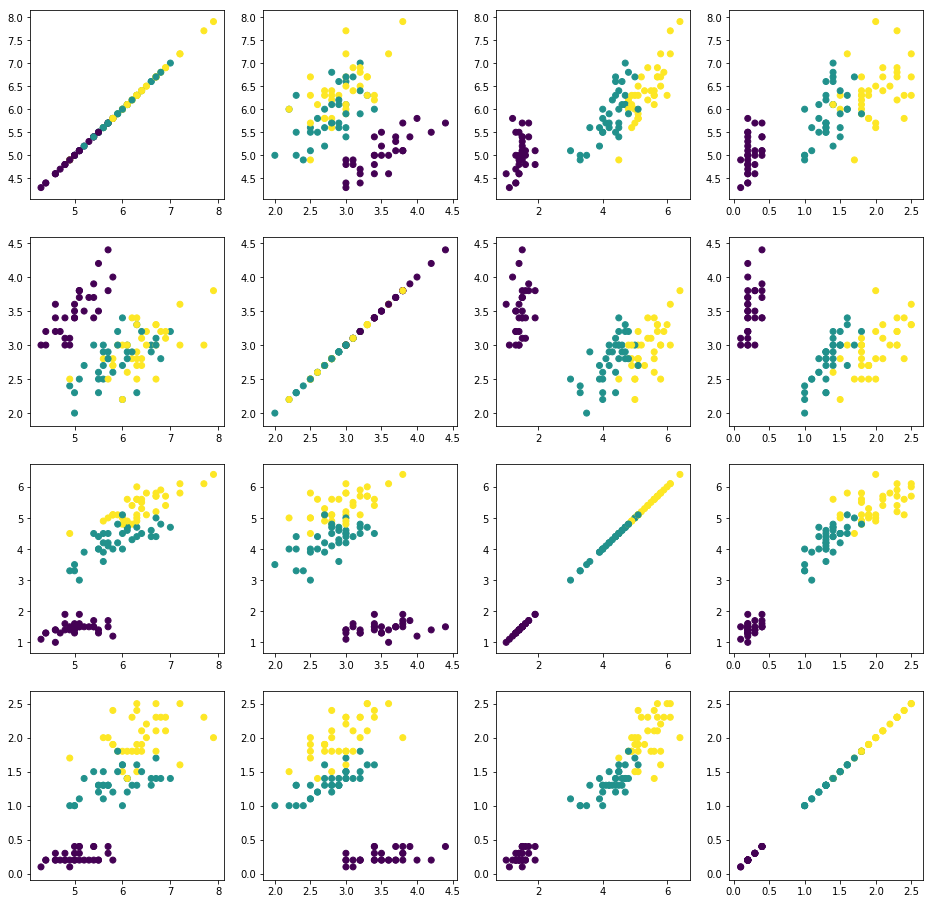

In [3]:
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,i+4*j+1)
        plt.scatter(train_x[:,i],train_x[:,j],c=train_y)

plt.gcf().set_size_inches((16,16))
plt.show()

In [20]:
# Some utility functions

# Quick function to evaluate accuracy given predictions
def accuracy(p,y):
    return np.mean(np.argmax(p,axis=1) == y)

# We'll do these a lot...
def toFloatVar(x):
    return Variable(torch.FloatTensor(x), requires_grad=False)

def toLongVar(x):
    return Variable(torch.LongTensor(x), requires_grad=False)


## Neural network

As before, we make a new class, but now we'll use the nn.Linear primitive to make our layers. nn.Linear is a subclass of nn.Module that implements $Ax+b$. When we use modules like this, all of their parameters are automatically added to our class, so we don't have to explicitly worry about keeping track of the Parameter() stuff ourselves. 

In [9]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier,self).__init__()
        
        # This defines a layer with 4 inputs and 64 outputs
        self.layer1 = nn.Linear(4,64)
        
        # A layer with 64 inputs and outputs
        self.layer2 = nn.Linear(64,64)
        
        # Finally, a layer with 64 inputs and 3 outputs
        self.layer3 = nn.Linear(64,3)
        
        # Using Adam this time, for much faster training
        self.optimizer = torch.optim.Adam(self.parameters(), lr = 1e-3)
        
    # After having defined the layers in __init__, we have to apply them
    # Each nn.Module subclass acts like a function, where calling it on an
    # input pushes that input to it's forward() method
    #
    # For clarity, each layer is being applied on a separate line, but you could do this
    # on one line, with a for loop, whatever.
    # Note we could easily output intermediate variables too if we liked.
    def forward(self,x):
        # Using ReLU nonlinearities here
        z = F.relu(self.layer1(x))
        z = F.relu(self.layer2(z))
        
        # Finally, a softmax nonlinearity. 'dim' specifies the axis over which the probability should be
        # normalized
        p = F.softmax(self.layer3(z), dim=1)
        
        return p
    
    # Now we'll use the categorical cross-entropy
    # There's a bit of a complex bit here, in that we need to specifically look at the predictions only
    # for the true labels, which are integer indices. To do this, we:
    # 
    # - Receive the labels as a LongTensor rather than a FloatTensor
    # - Use a list of indices to construct the entries that should belong to our loss
    #
    # We could also do this by making a one-hot encoding of the label and multiplying, but it would be more
    # expensive.
    def loss(self, y, p):
        ysize = y.size()
        idx = torch.arange(ysize[0]).long()
        
        return -torch.log( p[idx,y[idx]]).mean()
    
    # Same as before...
    def optimize(self, x, y):
        self.zero_grad()        

        p = self.forward(x)        
        loss = self.loss(y,p)        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.data.numpy()

## Training

Now we train the model...

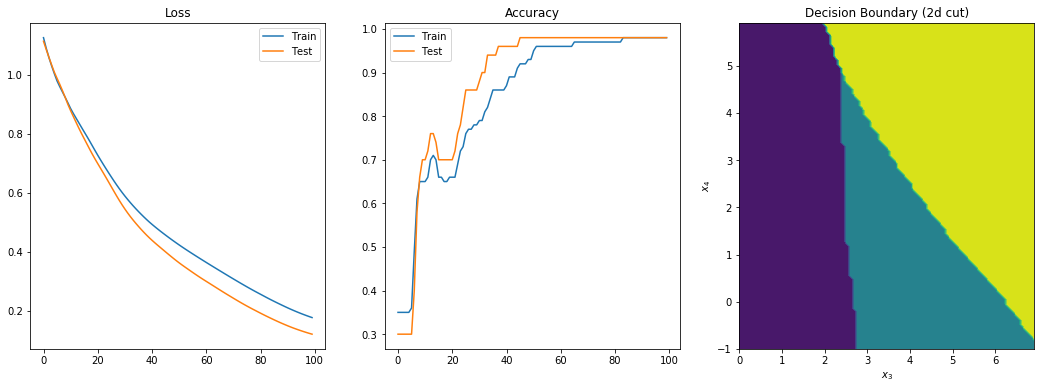

In [30]:
from IPython import display
import time

classifier = Classifier()

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(100):
    err = classifier.optimize(toFloatVar(train_x), toLongVar(train_y))
    train_loss.append(err)
    
    preds = classifier.forward(toFloatVar(train_x)).data.numpy()
    train_accuracy.append(accuracy(preds, train_y))
    
    # We also want to evaluate on the test set, to make sure we don't overfit
    
    preds = classifier.forward(toFloatVar(test_x)).data.numpy()
    
    idx = np.arange(preds.shape[0]).astype(np.int32)
    test_loss.append( -np.mean(np.log(preds[idx,test_y[idx]])) )
    test_accuracy.append(accuracy(preds, test_y))
    
    
    # This is all plotting stuff
    plt.clf()
    plt.subplot(1,3,1)
    plt.title("Loss")
    plt.plot(train_loss, label="Train")
    plt.plot(test_loss, label="Test")
    plt.legend()
    
    plt.subplot(1,3,2)
    plt.title("Accuracy")
    plt.plot(train_accuracy, label="Train")
    plt.plot(test_accuracy, label="Test")
    plt.legend()
    
    plt.subplot(1,3,3)
    plt.title("Decision Boundary (2d cut)")

    x1,x2 = np.meshgrid( np.arange(0,7,0.175/2.0), np.arange(-1,6,0.175/2.0) )
    x1 = x1.reshape((4*1600,1))
    x2 = x2.reshape((4*1600,1))
    x3 = np.zeros((4*1600,2))
    x3[:,0] += np.mean(train_x[:,0])
    x3[:,1] += np.mean(train_x[:,1])
    x = np.hstack([x3,x1,x2])
    y = classifier.forward(toFloatVar(x)).data.numpy()

    y = np.argmax(y,axis=1)
    plt.contourf(x1.reshape((80,80)), x2.reshape((80,80)), y.reshape((80,80)))
    plt.xlabel("$x_3$")
    plt.ylabel("$x_4$")
    
    plt.gcf().set_size_inches((18,6))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)

plt.clf()

## Saving and loading trained models

As it becomes more effort to retrain things (and as higher complexity means that training with different initializations will generally not find the same optima), it's useful to be able to save and load trained models. To do this, we use the state_dict() method of our class (again inherited from nn.Module).

In [31]:
# Saving a model
torch.save(classifier.state_dict(), open("iris_classifier.pth", "wb"))

In [32]:
# Loading a model
classifier.load_state_dict(torch.load("iris_classifier.pth"))